In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("lab02.ipynb")

# Lab 2:  Basics of Testing
Welcome to the second Data 102 lab! 

The goals of this lab are to get familiar with concepts in decision theory. We will learn more about testing, p-values and FDR control.

The code you need to write is commented out with a message **"TODO: fill..."**. There is additional documentation for each part as you go along.


## Collaboration Policy
Data science is a collaborative activity. While you may talk with others about the labs, we ask that you **write your solutions individually**. If you do discuss the assignments with others please **include their names** in the cell below.

## Submission
To submit this assignment, follow the instructions as outlined in the [Gradescope Submission Guidelines post](https://edstem.org/us/courses/52891/discussion/4179226) on Ed.

**For full credit, this assignment should be completed and submitted by Wednesday, January 31st, 2024 at 5 PM PST.**

## Collaborators
Write the names of your collaborators in this cell.

`<Collaborator Name> <Collaborator e-mail>`

# Setup
Let's begin by importing the libraries we will use. You can find the documentation for the libraries here:
* matplotlib: https://matplotlib.org/3.1.1/contents.html
* numpy: https://docs.scipy.org/doc/
* pandas: https://pandas.pydata.org/pandas-docs/stable/
* seaborn: https://seaborn.pydata.org/

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats
from scipy.stats import norm

import hashlib
%matplotlib inline

sns.set(style="dark")
plt.style.use("ggplot")

# Question 1: Hypothesis testing, LRT, decision rules, $p$-values.

The first question looks at the basics of testing. You will have to put yourself in the shoes of a detective who is trying to use 'evidence' to find the 'truth'. Given a piece of evidence $X$ your job will be to decide between two hypotheses. The two hypothesis you consider are:

_The null hypothesis:_
$$ H_0: X\sim \mathcal{N}(0,1)$$
_The alternative hypothesis:_
$$ H_1: X \sim \mathcal{N}(2,1)$$

Granted, you don't know the truth, but you have to make a decision that maximizes the True Positive Probability and minimizes the False Positive Probability.

**In this exercise you will look at:**
 - The intuitive relationship between Likelihood Ratio Test and decisions based on thresholding $X$.
 - The performance of a level-$\alpha$ test.
 - The distribution of $p$-values for samples from the null distribution as well as samples from the alternative.
 
#### Let's start by plotting the distributions of the null and alternative hypothesis.

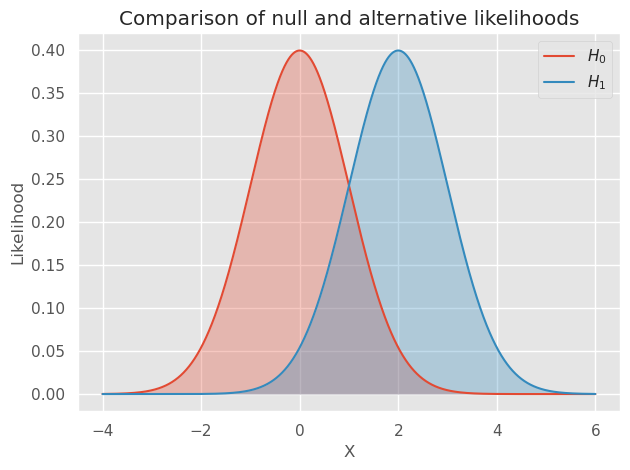

In [3]:
# NOTE: you just need to run this cell to plot the pdf; don't change this code.
def null_pdf(x):
    return norm.pdf(x,0,1)
def alt_pdf(x):
    return norm.pdf(x,2,1)

# Plot the distribution under the null and alternative
x_axis = np.arange(-4, 6, 0.001)

plt.plot(x_axis, null_pdf(x_axis), label = '$H_0$') # <- likelihood under the null
plt.fill_between(x_axis, null_pdf(x_axis), alpha = 0.3)

plt.plot(x_axis, alt_pdf(x_axis),  label = '$H_1$') # <- likelihood alternative
plt.fill_between(x_axis, alt_pdf(x_axis), alpha = 0.3)

plt.xlabel("X")
plt.ylabel("Likelihood")
plt.title("Comparison of null and alternative likelihoods");
plt.legend()
plt.tight_layout()
plt.show()

By inspecting the image above we can see that if the data lies towards the right, then it seems more plausible that the alternative is true. For example $X\geq1.64$ seems much less likely to belong to the null pdf than the alternative pdf.

### Likelihood Ratio Test
In class we said that the optimal test is the Likelihood Ratio Test (LRT), which is the result of the celebrated Neyman-Pearson Lemma. It says that the optimal level $\alpha$ test is the one that rejects the null (aka makes a discovery, favors the alternative) whenever:
$$LR(x):=\frac{f_1(x)}{f_0(x)} \geq \eta$$
where $\eta$ is chosen such that the false positive rate is equal to $\alpha$.

### But how does this result fit with the intuition that we should set a decision threshold based on the value of $X$ directly?

This exercise will formalize that intuition:

Let's start by computing the ratio of the likelihoods. The likelihood of $X\sim \mathcal N(\mu,\sigma)$ is:
$$f_{\sigma, \mu}(x) = \frac{1}{\sigma\sqrt{2\pi}} e^{-\frac{(x-\mu)^2}{2\sigma^2}}$$

Luckily `scipy` has a nifty function to compute the likelihood of gaussians `scipy.norm.pdf(x, mu, sigma)`

## 1a Calculate likelihood ratios

Complete the function below that computes the likelihood ratio for any value `x`.

In [4]:
# TODO: fill in the missing expression for the likelihood ratio in the function below
def calculate_likelihood_ratio(x):
    """
    Computes the likelihood ratio between the alternative and null hypothesis.
    
    Inputs:
        x: value for which to compute the likelihood ratio
    
    Outputs:
        lr : the likelihood ratio at point x
    """
    
    L0 = null_pdf(x)
    L1 = alt_pdf(x)
    LR = L1/L0 # TODO: fill the likelihood ratio
    return LR

In [5]:
grader.check("q1a")

q1a results: All test cases passed!

#### Let's plot the likelihood ratios for different values of $X$:

In [7]:
# Compute the likelihood ratio for X=1.64
X = 1.64
LR = calculate_likelihood_ratio(X)
print(LR)

3.59663972556928


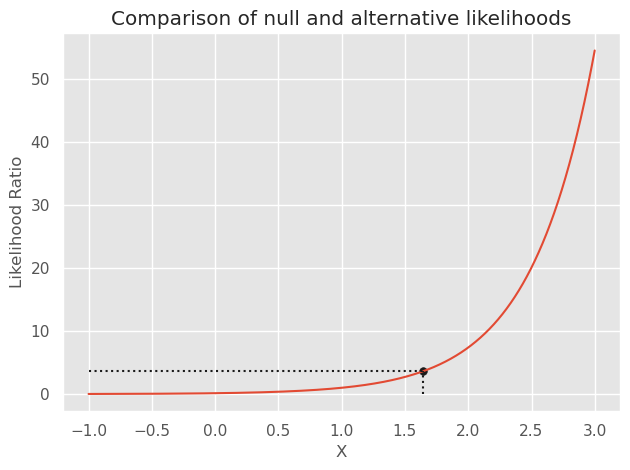

In [8]:
# The code below plots the LR for different values of X
# Once you've filled in `calculate_likelihood_ratio` run this cell and inspect the plot
x_axis = np.arange(-1, 3, 0.001)
plt.plot(x_axis, calculate_likelihood_ratio(x_axis))
plt.vlines(X, 0, LR, linestyle="dotted", color='k')
plt.hlines(LR, -1, X, linestyle="dotted", color='k')
plt.scatter(X, LR, 30, color='k')
plt.xlabel("X")
plt.ylabel("Likelihood Ratio")
plt.title("Comparison of null and alternative likelihoods");
plt.tight_layout()
plt.show()

The plot above illustrates that deciding based on LRT with $\eta = 3.6$ (the dotted horizontal line) is equivalent to deciding in the favor of the alternative whenever $X\geq 1.64$ (the dotted vertical line). The set $[1.64, +\infty)$ is called the **rejection region** of the test, because for all X values in the rejection region the test rejects the null in the favor of the alternative. This illustrates that our intuition was correct.

When thinking in terms of likelihood ratios it seems very tricky to compute the False Positive Rate (FPR), however in this case we can bypass that by testing based on the value of $X$.

#### The figure below illustrates pictorially the FPR when testing based on the threshold $X\geq1.64$


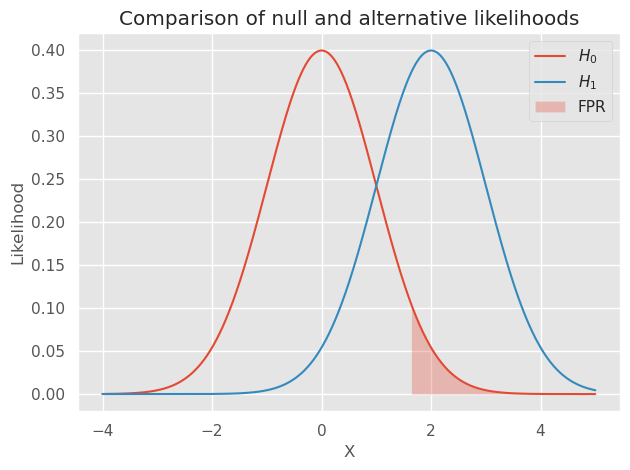

In [9]:
x_axis = np.arange(-4, 5, 0.001)


plt.plot(x_axis, null_pdf(x_axis), label = '$H_0$') # <- likelihood under the null
plt.plot(x_axis, alt_pdf(x_axis),  label = '$H_1$') # <- likelihood alternative

rejection_region = np.arange(X, 5, 0.001) # <- truncate the true rejection region for plotting purposes
plt.fill_between(rejection_region, null_pdf(rejection_region), alpha = 0.3, label="FPR")

plt.xlabel("X")
plt.ylabel("Likelihood")
plt.title("Comparison of null and alternative likelihoods");
plt.legend()
plt.tight_layout()
plt.show()

Under the null hypothesis it is still possible to observe values in the tail of distribution. The probability of that happening is exactly FPR (and it is illustrated by the shaded area under the null curve). Assume that we are using the test that rejects for all $X \geq \tau$ (in the example above, $\tau = 1.64$). FPR can then be computed as:

$$FPR(\tau) = \mathbb{P}\{X>\tau|H_0 \text{ is true}\} = 1 - \mathbb{P}\{X<\tau|H_0 \text{ is true}\} = 1 - F(
\tau)$$

where $F(\cdot)$ denotes the CDF of the null distributions, which in this case is the standard gaussian. 

## 1b Calculate the probability of False Positives
In the cell below calculate the FPR for this test. 

**Hint:** the cdf of a standard normal might come in handy for this function: `scipy.stats.norm.cdf`

In [10]:
# TODO: fill in the missing expression for FPR
def calculate_fpr(tau):
    """
    Calculates the FPR for the test based on thresholding X>=tau.
    It assumes that the null distribution is the standard gaussian N(0,1)
    
    Inputs:
        tau: test threshold
    
    Outputs:
        fpr: false positive rate
    """
    
    fpr = 1 - scipy.stats.norm.cdf(tau)
    return fpr

In [11]:
grader.check("q1b")

q1b results: All test cases passed!

#### Let's now compute the FPR for a test that rejects whenever $X\geq 1.64$

In [13]:
# Calculate the false positive rate
X = 1.64 # tau
fpr = calculate_fpr(X)
print(fpr)

0.050502583474103746


#### Looks like we got really lucky!!! The threshold we choose has a FPR of $\sim 5\%$.

## 1c Make a level-$\alpha$ decision rule

Complete the function below to create a decision rule that has $FPR=\alpha$. Given that we are working with Gaussian this test is exactly the Z-score test that you might have learned in previous classes.

**Hint**, the inverse cdf of a standard normal might come in handy for this function: `scipy.stats.norm.ppf`

In [14]:
# TODO: complete this function
def make_decision(X, alpha):
    """
    Makes a decision whether to reject the null hypothesis for point X at level alpha
    
    Inputs:
        X: point at which to test
        alpha: desired FPR rate for the decision rule (also known as significance level)
    
    Outputs:
        decision: {0, 1} or {False, True}
            1/True: reject the null
            0/False: fail to reject the null
    """
    threshold = scipy.stats.norm.ppf(1-alpha) # TODO: compute the threshold for which the FPR of the test is equal to alpha (see Hint)
    decision = (X > threshold) # TODO: compute the decision; 1 stands for rejecting the null
    return decision

In [ ]:
1 - F(tau) = alpha 
F(tau) = 1 - alpha
tau = F^(-1)(1-alpha)

In [15]:
# Once you've filled `make_decision` run this to perform this test 
# for a few values of X at different levels alpha
X_vals = np.array([0, 0.5, 1, 2, 3])
alphas = np.array([0.01, 0.05, 0.1, 0.2])
for alpha in alphas:
    decisions = make_decision(X_vals, alpha)
    print(f'At FPR={alpha} the null hypothesis is rejected for these X values: {X_vals[decisions==1]}')

At FPR=0.01 the null hypothesis is rejected for these X values: [3.]
At FPR=0.05 the null hypothesis is rejected for these X values: [2. 3.]
At FPR=0.1 the null hypothesis is rejected for these X values: [2. 3.]
At FPR=0.2 the null hypothesis is rejected for these X values: [1. 2. 3.]


In [16]:
grader.check("q1c")

q1c results: All test cases passed!

## 1d Compute $p$-values
Let's take a step back and look at what have we accomplished. We came up with a decision rule that rejects the null hypothesis for a piece of evidence $X$. The test is parametrized at a level $\alpha$ chosen a-priori to reflect our aversion to False Positives.

However, testing returns a binary output: _Reject_ or _Fail to reject_ (1 or 0). In the example above, at level $\alpha = 0.01$ we reject the null only for $X=3$, however at level $\alpha = 0.05$ we reject the null for $X=2$ as well. We have already seen that increasing the FPR increases the rejection region of the test. However you might wonder for $X=2$, what is the smallest $\alpha$ level, such that the corresponding test rejects the null hypothesis in the favor of the alternative?

$p$-values try to answer exactly that question: 

**"Given a point $X$, and a family of tests parametrized by $\alpha$, what is the smallest $\alpha$ for which the test rejects the null?"**

That is, for $\varphi_\alpha(X)$ an $\alpha$-level test, the $p$-value is

$$p(X) = \min_{\alpha} \varphi_\alpha(X) = 1.$$

Hence, $p$-values tell us something more than just a binary accept/reject answer. The $p$-value associated with the point $X$ quantifies the *strength of the evidence in the favor of rejecting the null*. Small $p$-values suggest that the evidence is significant, while large $p$-values suggest that there is little evidence.

### In the cell below write a function that computes the $p$-values, for a point $X$. 

**Hint:** You already wrote that function in one of the previous exercises, it just had a different name.

In [17]:
# TODO: complete this function
def calculate_p_value(X):
    """
    Calculates the P-values for the point X
    
    Inputs:
        X: data point
    
    Outputs:
        p_value: P(X)
    """
    p_value = 1 - scipy.stats.norm.cdf(X)
    return(p_value)

In [18]:
# Once you've filled `calculate_p_value`, run this to compute P-Values for a few X samples.
X_vals = np.array([0, 0.5, 1, 2, 3])
for X in X_vals:
    print(f'X = {X}, P(X) = {calculate_p_value(X)}')

X = 0.0, P(X) = 0.5
X = 0.5, P(X) = 0.3085375387259869
X = 1.0, P(X) = 0.15865525393145707
X = 2.0, P(X) = 0.02275013194817921
X = 3.0, P(X) = 0.0013498980316301035


In [19]:
grader.check("q1d")

q1d results: All test cases passed!

<!-- BEGIN QUESTION -->

## 1e Distribution of $p$-values
Now, we are going to imagine that we have a bunch of samples (each drawn either from the null distribution or the alternative distribution). We want to predict whether each sample was generated from $H_0$ or $H_1$ by looking at its p-value. As a reminder, the two hypothesis to consider are:

_The null hypothesis:_
$$ H_0: X\sim \mathcal{N}(0,1)$$
_The alternative hypothesis:_
$$ H_1: X \sim \mathcal{N}(2,1)$$

In the example below, we simulate $n=10000$ draws, in which approximatively 80% come from the null distribution (Reality = 0), and approximately 20% come from the alternative distribution (Reality = 1).

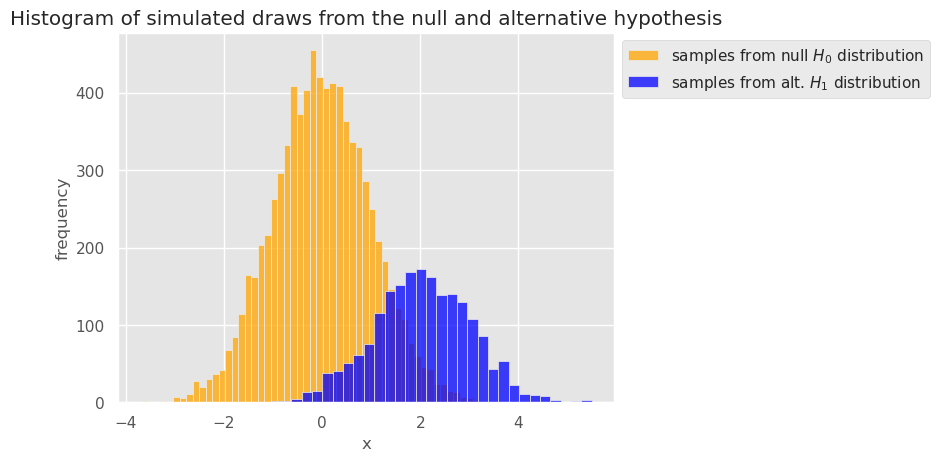

In [21]:
# NOTE: you just need to run this cell to instantiate variables; don't change this code.

rs = np.random.RandomState(0)
n = 10000

# roughly 80% of the data comes from the null distribution
# true_values is an n-dimensional array of indicators, where "1" means that x is from the alternative 
true_values = rs.binomial(1, 0.2, n)

# null distribution is N(0, 1) and alternative distribution is N(2, 1)
x_obs = rs.randn(n) + 2*true_values

sns.histplot(x_obs[np.where(true_values == 0)],  label="samples from null $H_0$ distribution", kde=False, color='orange')
sns.histplot(x_obs[np.where(true_values == 1)],  label="samples from alt. $H_1$ distribution", kde=False, color='blue')

plt.title("Histogram of simulated draws from the null and alternative hypothesis")
plt.xlabel("x")
plt.ylabel("frequency")
plt.legend(bbox_to_anchor=(1,1));

Now, let's take these simulated draws, calculate their $p$-values, and visualize the $p$-values corresponding to each of these simulated draws.

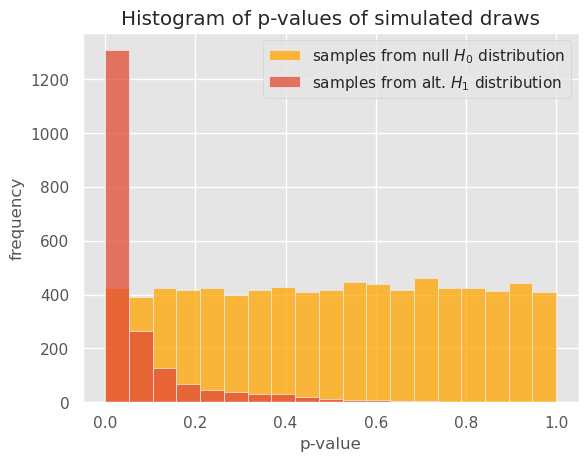

In [22]:
# NOTE: you just need to run this cell and understand what it does; no code to modify or write here. 
# calculate the p-values for each individual hypothesis
p_values = calculate_p_value(x_obs)

bins = np.linspace(0,1,num=20)
sns.histplot(p_values[np.where(true_values == 0)],  label="samples from null $H_0$ distribution", kde=False, bins=bins, color='orange')
sns.histplot(p_values[np.where(true_values == 1)],  label="samples from alt. $H_1$ distribution", kde=False, bins=bins)
plt.legend(bbox_to_anchor=(1,1))
plt.title("Histogram of p-values of simulated draws")
plt.xlabel("p-value")
plt.ylabel("frequency");

**Using the histogram of our calculated $p$-values, write down a few of your observations ($\le$ 3 sentences). In particular, your observations should address:**
1. The shape of the distribution of $p$-values under the null hypothesis,
2. how it contrasts with the shape of the $p$-values under the alternative hypothesis,
3. ...and why, for any given $p$-value close to zero, we're able to state with high confidence that the data point was generated under the alternative hypothesis.

_Type your answer here, replacing this text._

<!-- END QUESTION -->

# Question 2: Multiple Testing, Procedures to control false discovery rate.

In the previous example we looked primarily at controling row-wise quantities. And specifically we came up with a decision rules that controls the false positive rate to a desired level $\alpha$. 

Now we are switching perspectives and are thinking about a column-wise quantity. Our goal is to control the probability of false discoveries in this decision-making process for multiple hypothesis testing.

We will use three methods for making discoveries:

1. Naive thresholding (ignoring that multiple testing is happening)
2. Using Bonferroni correction to account for multiple testing
3. The Benjamini-Hochberg procedure for multiple testing

    
For each method, we will assess the decisions made on a simulated data set. 

## 2a) Fill in the following functions regarding confusion matrices.
These functions will be important for reporting your results in a standardized way; later code assumes that you have implemented them so start here.

In [23]:
# TODO: complete this function
def report_results(predicted_discoveries, truth):
    """
    Produces a dictionary with counts for the true positives, true negatives,
    false negatives, and false positives from the input `predicted_discoveries`
    and `truth` arrays.
    
    Inputs:
      predicted discoveries: array of 0/1 values where 1 indicates a "discovery".
      truth: array of 0/1 values where 1 indicates a draw from the alternative.
    
    Outputs: a dictionary of TN, TP, FN, and FP counts.
    """   
    
    # populate the following dictionary with counts (NOT rates)
    # TODO: fill in each of these counts
    TP_count = sum(predicted_discoveries * truth)
    TN_count = sum((1 - predicted_discoveries) * (1 - truth))
    FP_count = sum(predicted_discoveries * (1 - truth))
    FN_count = sum((1 - predicted_discoveries) * truth)
    
    results_dictionary = {"TN_count": TN_count,
                          "TP_count": TP_count,
                          "FN_count": FN_count,
                          "FP_count": FP_count,
                         }
    
    # this function is defined for you below
    print_confusion_matrix(results_dictionary)
    return results_dictionary


In [24]:
# TODO: complete this function
def print_false_discovery_fraction(results_dictionary):
    total_predicted_discoveries = results_dictionary["TP_count"] + results_dictionary["FP_count"]
    false_predicted_discoveries = results_dictionary["FP_count"]
    
    # TODO: fill in - compute the false discovery fraction from the `results` dictionary
    false_discovery_frac = false_predicted_discoveries/total_predicted_discoveries
    
    print("total discoveries: {0}".format(total_predicted_discoveries))
    print("fraction of discoveries which were actually false: {0:.3f}".format(false_discovery_frac))
    return total_predicted_discoveries, false_discovery_frac

In [25]:
def print_confusion_matrix(res_dict):
    # This is a helper function to print the confusion matrix. You don't need to modify this code.
    results_df = pd.DataFrame(data = {"Decision = 0": [res_dict['TN_count'], res_dict['FN_count']], 
                                      "Decision = 1":  [res_dict['FP_count'], res_dict['TP_count']]},
                             index=["Truth = 0", "Truth = 1"])
    print(results_df)

As a quick sanity check, run the cell below to check your functions on a toy example. 

**Note**: While the autograder will check the correctness of these results, we recommend that you try working out the TP, FP, TN, and TP counts and false discovery fraction in this toy example for yourself before checking your code against the autograder.

In [26]:
# Do not modify
toy_truth = np.append(np.zeros(3), np.ones(7)) 
toy_predicted_discoveries = np.array([0, 1, 1, 0, 0, 0, 1, 1, 1, 1]) 
toy_dict = report_results(toy_predicted_discoveries, toy_truth)
toy_false_discovery_frac = print_false_discovery_fraction(toy_dict)

           Decision = 0  Decision = 1
Truth = 0           1.0           2.0
Truth = 1           3.0           4.0
total discoveries: 6.0
fraction of discoveries which were actually false: 0.333


In [27]:
grader.check("q2a")

q2a results: All test cases passed!

## 2b) Naive thresholding
Here we will investigate the result of using the threshold $\alpha = 0.05$ to test each hypothesis independently, ignoring that we are in a multiple testing scenario. 

Fill in the code for the function below to test each hypothesis at significance level $\alpha$.

**Hint:** This is very simular to the `make_decision` function you wrote in Question 1. There, the input to the test was the sample value $X$, however here the input is the $p$-value $p(X)$.

In [28]:
# TODO: calculate decisions based on thresholding
def naive_alpha_threshold(p_values, alpha):
    """
    Returns decisions on p-values using naive (uncorrected) thresholding.
    
    Inputs:
        p_values: array of p-values
        alpha: threshold (significance level)
    
    Returns:
        decisions: binary array of same length as p-values, where `decisions[i]` is 1
        if `p_values[i]` is deemed significant at level `alpha`, and 0 otherwize
    """
    
    decisions = (p_values < alpha)
    return decisions

In [29]:
# Once you've filled in `naive_alpha_threshold`, run this cell to print the results.
# set alpha 
alpha = 0.05

# Using the p-values from Part 1.e, we compute the decision according to the naive function
naive_decisions = naive_alpha_threshold(p_values, alpha)

naive_results = report_results(naive_decisions,true_values)
print()
print_false_discovery_fraction(naive_results)
print()

           Decision = 0  Decision = 1
Truth = 0          7628           400
Truth = 1           679          1293

total discoveries: 1693
fraction of discoveries which were actually false: 0.236



In [30]:
grader.check("q2b")

q2b results: All test cases passed!

## 2c Bonferroni Correction
Here, we will investigate the result of using Bonferroni-corrected $p$-values to declare discoveries.
First, implement the Bonferroni procedure in the function below. 

Recall that for testing $n$ hypotheses with family-wise error rate (FWER) $\leq \alpha$, the resulting procedure is to test each hypothesis with significance $\frac{\alpha}{n}$.

In [34]:
# TODO: calculate the decisions based on the bonferroni correction procedure.
def bonferroni(p_values, alpha_total):
    """
    Returns decisions on p-values using the Bonferroni correction.
    
    Inputs:
        p_values: array of p-values
        alpha_total: desired family-wise error rate (FWER = P(at least one false discovery))
    
    Returns:
        decisions: binary array of same length as p-values, where `decisions[i]` is 1
        if `p_values[i]` is deemed significant, and 0 otherwise
    """
    
    decisions = (p_values < alpha_total/len(p_values))
    return decisions

In [35]:
# Once you've filled in `bonferroni`, run this cell to print the results. 
bonferroni_decisions = bonferroni(p_values, alpha)

bonferroni_results = report_results(bonferroni_decisions,true_values)
print()
print_false_discovery_fraction(bonferroni_results)
print()

           Decision = 0  Decision = 1
Truth = 0          8028             0
Truth = 1          1957            15

total discoveries: 15
fraction of discoveries which were actually false: 0.000



In [36]:
grader.check("q2c")

q2c results: All test cases passed!

## 2d Benjamini-Hochberg
Now we will investigate the result of implementing Benjamini-Hochberg procedure for multiple hypothesis testing.
First, implement the Benjamini-Hochberg procedure in the function below. 

Recall that for testing $n$ hypotheses with false discovery rate (FDR) $\leq \alpha$, the resulting procedure is to find the largest $p$-value less than or equal to $k \frac{\alpha}{n}$, where $k$ is given by the $p$-value's index after sorting, and $n$ represents the number of hypotheses you've tested. Once found, we then declare a discovery for all $p$-values with value less than or equal to this $p$-value. 

In [37]:
# TODO: calculate decisions based on Benjamini-Hochberg procedure
def benjamini_hochberg(p_values, alpha):
    """
    Returns decisions on p-values using Benjamini-Hochberg.
    
    Inputs:
        p_values: array of p-values
        alpha: desired FDR (FDR = E[# false positives / # positives])
    
    Returns:
        decisions: binary array of same length as p-values, where `decisions[i]` is 1
        if `p_values[i]` is deemed significant, and 0 otherwise
    """
    n = len(p_values)
    sorted_p = np.sort(p_values)
    max_k = max([k for k in range(n) if sorted_p[k] <= (k+1)*alpha/n])
    threshold = sorted_p[max_k]

    decisions = (p_values <= threshold)
    return decisions

Now, assess the result of applying the Benjamini Hochberg procedure to the simulated data.

In [38]:
# Once you've filled in `benjamini_hochberg`, run this cell to print the results.
bh_decisions = benjamini_hochberg(p_values, alpha)

bh_results = report_results(bh_decisions,true_values)
print()

print_false_discovery_fraction(bh_results)


           Decision = 0  Decision = 1
Truth = 0          8011            17
Truth = 1          1581           391

total discoveries: 408
fraction of discoveries which were actually false: 0.042


(408, 0.041666666666666664)

In [39]:
grader.check("q2d")

q2d results: All test cases passed!

<!-- BEGIN QUESTION -->

## 2e Conclusions
Finally, write a short ($\le$ 4 sentences) summary comparing the three different methods from this problem.

_Type your answer here, replacing this text._

<!-- END QUESTION -->

## Congrats! You've reached the end of the lab!

Before you submit to Gradescope, make sure you pass all the autograded portions of this lab. Run the cell below to generate a PDF of your lab submission, and run the last cell to generate a zip file of your lab submission. 

To submit your lab to Gradescope, submit the PDF to Lab 2 Written and the zip file to Lab 2 Code. Please make sure that the relevant text, outputs, and graphs appear in your PDF file.

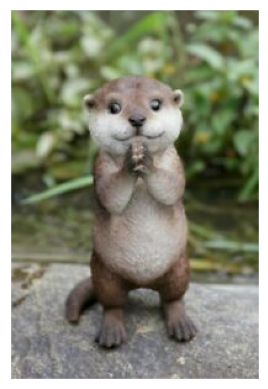

In [40]:
import matplotlib.image as mpimg
from otter.export import export_notebook
from os import path
from IPython.display import display, HTML
export_notebook("lab02.ipynb", filtering=True, pagebreaks=True)
if(path.exists('lab02.pdf')):
    img = mpimg.imread('baby_otter.jpg')
    imgplot = plt.imshow(img)
    imgplot.axes.get_xaxis().set_visible(False)
    imgplot.axes.get_yaxis().set_visible(False)
    plt.show()
    display(HTML("Download your PDF <a href='lab02.pdf' download>here</a>."))

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True)